# Incorporating Pretrained Embeddings

## Douglas Rice


*This tutorial was originally created by Burt Monroe for his prior work with the Essex Summer School. I've updated and modified it.*

In this notebook, we'll update our classifier to go beyond the one-hot representation of text to incorprate pre-trained embeddings as features. 

## Load Modules

We'll start by loading the modules we need for estimating the model and getting our workspace set up.

In [2]:
!pip install tensorflow-hub
!pip install tensorflow-datasets

In [3]:
!pip install tensorflow

In [4]:
import os
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_datasets as tfds

print("Version: ", tf.__version__)
print("Eager mode: ", tf.executing_eagerly())
print("Hub version: ", hub.__version__)
print("GPU is", "available" if tf.config.list_physical_devices("GPU") else "NOT AVAILABLE")

Version:  2.8.0
Eager mode:  True
Hub version:  0.12.0
GPU is NOT AVAILABLE


We're going to use a slightly different version of the imdb data available from tensorflow_datasets.

In [5]:
train_data, validation_data, test_data = tfds.load(
    name="imdb_reviews", 
    split=('train[:60%]', 'train[60%:]', 'test'),
    as_supervised=True)

Dl Completed...: 100%|██████████| 1/1 [00:00<00:00, 19.26 url/s]


UnknownError: Failed to rename: ~\tensorflow_datasets\imdb_reviews\plain_text\1.0.0.incomplete58HA0A to: ~\tensorflow_datasets\imdb_reviews\plain_text\1.0.0 : Access is denied.
; Input/output error

In [ ]:
train_examples_batch, train_labels_batch = next(iter(train_data.batch(10)))
train_examples_batch

<tf.Tensor: shape=(10,), dtype=string, numpy=
array([b"This was an absolutely terrible movie. Don't be lured in by Christopher Walken or Michael Ironside. Both are great actors, but this must simply be their worst role in history. Even their great acting could not redeem this movie's ridiculous storyline. This movie is an early nineties US propaganda piece. The most pathetic scenes were those when the Columbian rebels were making their cases for revolutions. Maria Conchita Alonso appeared phony, and her pseudo-love affair with Walken was nothing but a pathetic emotional plug in a movie that was devoid of any real meaning. I am disappointed that there are movies like this, ruining actor's like Christopher Walken's good name. I could barely sit through it.",
       b'I have been known to fall asleep during films, but this is usually due to a combination of things including, really tired, being warm and comfortable on the sette and having just eaten a lot. However on this occasion I fell 

In [ ]:
train_labels_batch

<tf.Tensor: shape=(10,), dtype=int64, numpy=array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])>

## Employing Pretrained Embeddings: Frozen

We start by using the pre-trained embeddings "as-is". That is, the distribution of weights will be "frozen" as is for each of the words. 

The first step, then, is to identify the pre-trained embeddings we would like to employ as our feature set. We will use the 50-dimensional "Token based text embedding trained on English Google News 7B corpus" available from TensorflowHub at "https://tfhub.dev/google/nnlm-en-dim50/2". (It is worth noting that they do not specify, and I do not know, several important things about these embeddings: (1) what year(s) of data were they trained on, (2) what method (word2vec, GloVe, etc.), (3) what parameters, esp. context window size.

We need to indicate, of course, where Python should look to find the pre-trained embeddings on TensorflowHub. We specify that in the first line below.

Then we'll add a "hub" "Keras Layer" at the front of our model. This takes each training example (think of it as multi-hot vector of ones and zeros, the length of the vocabulary, V) and multiply it by the embedding matrix, V x 50, producing a 1x50 input equivalent to the *average of the embeddings for the individual words in a document*.

To get an idea of what this does, we'll look at the first three documents after they've been run through this layer.

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=False)
hub_layer(train_examples_batch[:3])

<tf.Tensor: shape=(3, 50), dtype=float32, numpy=
array([[ 0.5423194 , -0.01190171,  0.06337537,  0.0686297 , -0.16776839,
        -0.10581177,  0.168653  , -0.04998823, -0.31148052,  0.07910344,
         0.15442258,  0.01488661,  0.03930155,  0.19772716, -0.12215477,
        -0.04120982, -0.27041087, -0.21922147,  0.26517656, -0.80739075,
         0.25833526, -0.31004202,  0.2868321 ,  0.19433866, -0.29036498,
         0.0386285 , -0.78444123, -0.04793238,  0.41102988, -0.36388886,
        -0.58034706,  0.30269453,  0.36308962, -0.15227163, -0.4439151 ,
         0.19462997,  0.19528405,  0.05666233,  0.2890704 , -0.28468323,
        -0.00531206,  0.0571938 , -0.3201319 , -0.04418665, -0.08550781,
        -0.55847436, -0.2333639 , -0.20782956, -0.03543065, -0.17533456],
       [ 0.56338924, -0.12339553, -0.10862677,  0.7753425 , -0.07667087,
        -0.15752274,  0.01872334, -0.08169781, -0.3521876 ,  0.46373403,
        -0.08492758,  0.07166861, -0.00670818,  0.12686071, -0.19326551,
 

Now, we'll define our architecture using the hub layer we defined above. To do so, we specify our model in a slightly different way now. We'll use the `.add()` functionality to add a layer to our model after first specifying the model type. Let's start with a simple framework that takes the `hub_layer` as input, passing that to a dense layer with 16 nodes, and finally to a dense layer with 1 node. 

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 50)                48190600  
                                                                 
 dense (Dense)               (None, 16)                816       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 833
Non-trainable params: 48,190,600
_________________________________________________________________


Note that there are over 48 million parameters, but only 833 of these are trainable. The 48,190,600 untrainable parameters are the weights converting each known token in the embeddings, apparently 963,812 of them, into the 50 embedding outputs. These weights remain unchanged in training (and most of them don't affect the outcome at all, because most of the 963,812 vocabulary words don't appear in the IMDB corpus).

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 2s 49ms/step - loss: 0.5299 - accuracy: 0.7147 - val_loss: 0.5292 - val_accuracy: 0.7141
Epoch 2/20
30/30 [==============================] - 2s 50ms/step - loss: 0.5268 - accuracy: 0.7147 - val_loss: 0.5263 - val_accuracy: 0.7234
Epoch 3/20
30/30 [==============================] - 2s 50ms/step - loss: 0.5249 - accuracy: 0.7202 - val_loss: 0.5250 - val_accuracy: 0.7308
Epoch 4/20
30/30 [==============================] - 2s 50ms/step - loss: 0.5212 - accuracy: 0.7229 - val_loss: 0.5219 - val_accuracy: 0.7266
Epoch 5/20
30/30 [==============================] - 2s 49ms/step - loss: 0.5191 - accuracy: 0.7245 - val_loss: 0.5215 - val_accuracy: 0.7170
Epoch 6/20
30/30 [==============================] - 2s 50ms/step - loss: 0.5177 - accuracy: 0.7242 - val_loss: 0.5187 - val_accuracy: 0.7288
Epoch 7/20
30/30 [==============================] - 2s 51ms/step - loss: 0.5162 - accuracy: 0.7277 - val_loss: 0.5180 - val_accuracy: 0.7321
Epoch 8/20
30

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams['figure.dpi'] = 200 #Makes graphics bigger

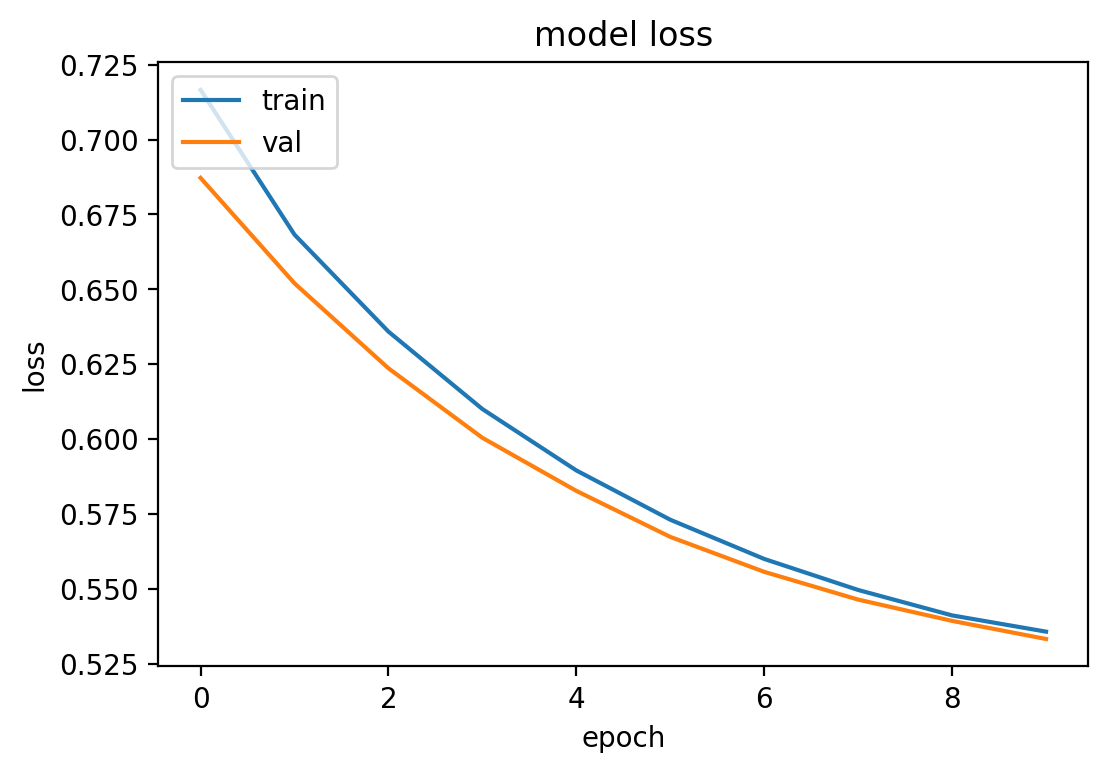

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

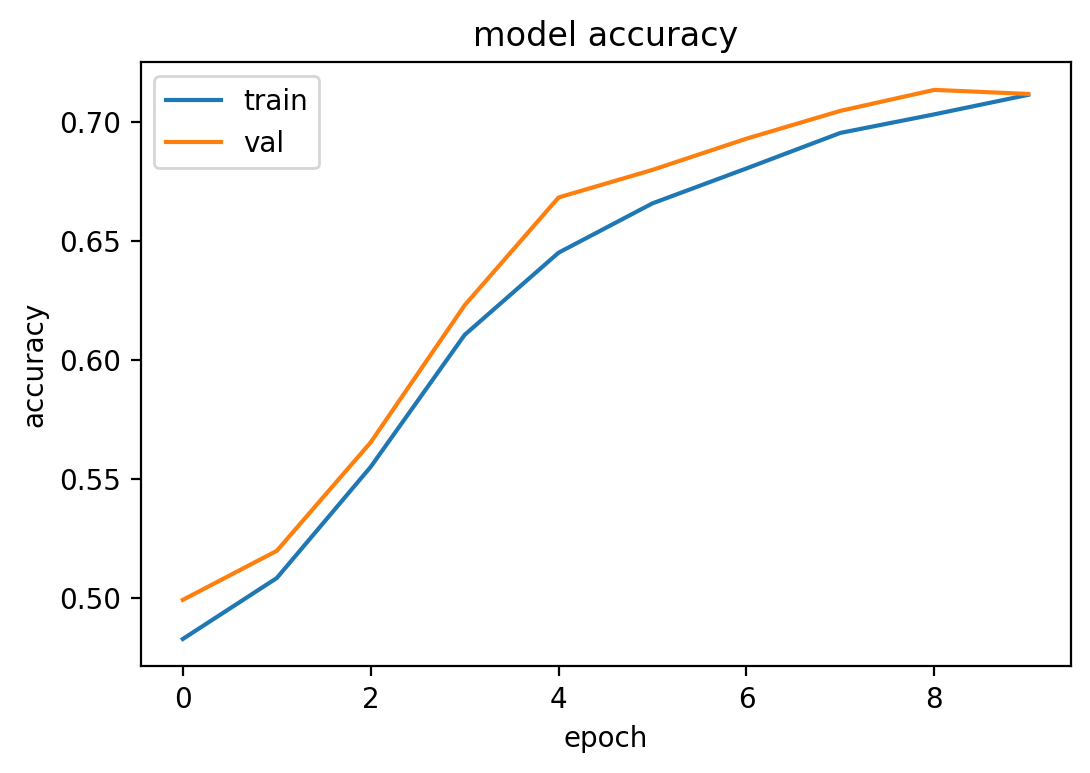

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 3s - loss: 0.5406 - accuracy: 0.7042 - 3s/epoch - 58ms/step
loss: 0.541
accuracy: 0.704


Yikes. That's not good. The embeddings were *supposed* to help us build a better feature set, but we're doing substantially worse. Why? The plots suggest maybe we could gain a bit of leverage by letting this run longer. But more likely is that the embeddings just aren't give us any more information than we already had. What if we could update those embeddings?

## Fine-tuning the embeddings

Let's try that out. We'll do everything the same, but we'll let the embedding layer be trainable. Programming-wise, this is exceptionally easy.

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim50/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

But under the hood, things just got a lot more complicated. This next chunk will show us how: 

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_4 (Dense)             (None, 16)                816       
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________


Look at the summary. We now 48 million trainable parameters; that's scarier than it seems though. Many of those apply to tokens that appear in the embeddings but not in the IMDB corpus. Still, we can reasonably expect estimation is going to take longer now.

In [ ]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=20,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Epoch 1/20
30/30 [==============================] - 3s 75ms/step - loss: 0.0130 - accuracy: 0.9996 - val_loss: 0.4059 - val_accuracy: 0.8652
Epoch 2/20
30/30 [==============================] - 3s 70ms/step - loss: 0.0067 - accuracy: 0.9997 - val_loss: 0.4421 - val_accuracy: 0.8656
Epoch 3/20
30/30 [==============================] - 3s 69ms/step - loss: 0.0040 - accuracy: 0.9998 - val_loss: 0.4730 - val_accuracy: 0.8646
Epoch 4/20
30/30 [==============================] - 3s 71ms/step - loss: 0.0027 - accuracy: 0.9999 - val_loss: 0.4993 - val_accuracy: 0.8650
Epoch 5/20
30/30 [==============================] - 3s 70ms/step - loss: 0.0019 - accuracy: 0.9999 - val_loss: 0.5207 - val_accuracy: 0.8644
Epoch 6/20
30/30 [==============================] - 3s 68ms/step - loss: 0.0014 - accuracy: 0.9999 - val_loss: 0.5417 - val_accuracy: 0.8645
Epoch 7/20
30/30 [==============================] - 3s 69ms/step - loss: 0.0011 - accuracy: 0.9999 - val_loss: 0.5590 - val_accuracy: 0.8628
Epoch 8/20
30

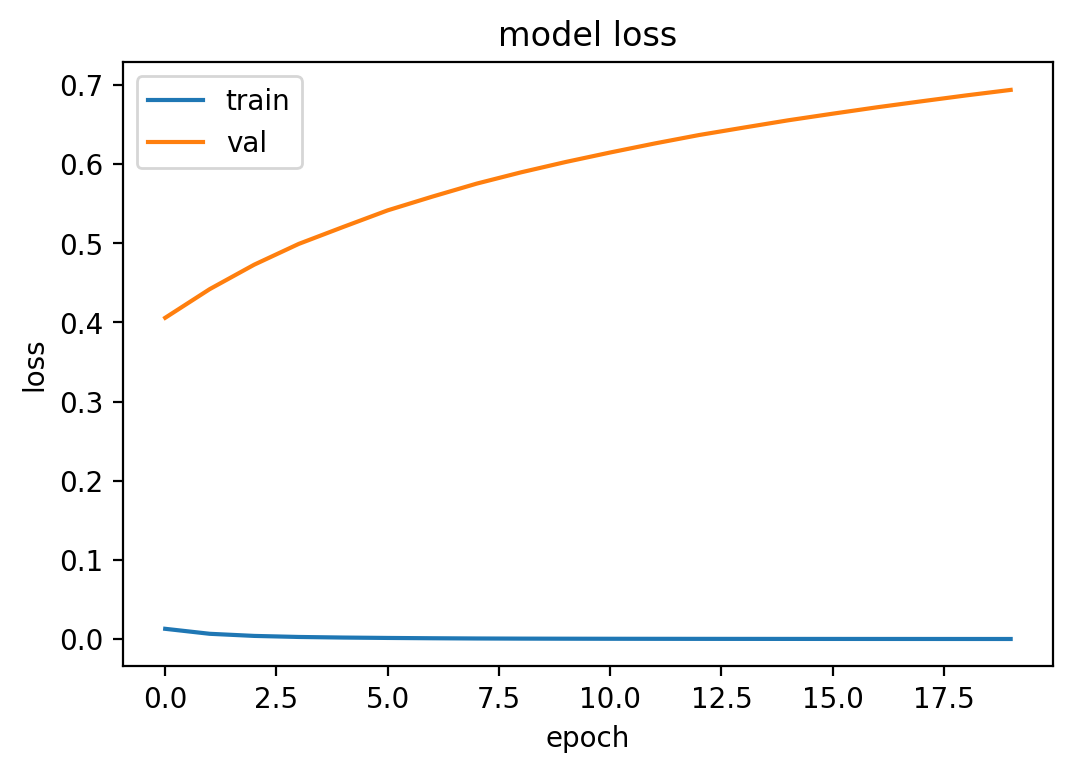

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

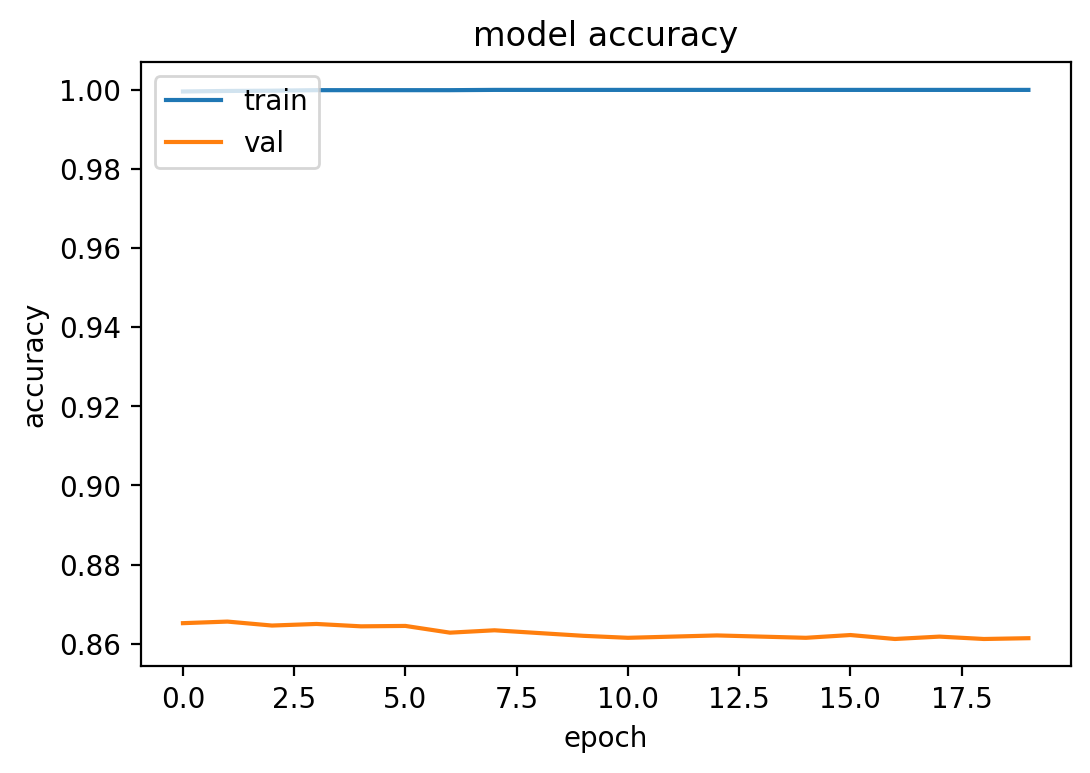

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 2s - loss: 0.7608 - accuracy: 0.8434 - 2s/epoch - 36ms/step
loss: 0.761
accuracy: 0.843


That's definitely overfit!

We'll rerun with just 5 epochs.

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=5,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_1 (KerasLayer)  (None, 50)                48190600  
                                                                 
 dense_6 (Dense)             (None, 16)                816       
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                                 
Total params: 48,191,433
Trainable params: 48,191,433
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
30/30 [==============================] - 3s 73ms/step - loss: 0.4888 - accuracy: 0.8501 - val_loss: 0.4643 - val_accuracy: 0.7860
Epoch 2/5
30/30 [==============================] - 3s 71ms/step - loss: 0.2727 - accuracy: 0.9593 - val_loss: 0.3482 - val_accuracy: 0.8508
Epoch 3/5
30/30 [=========

In [ ]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 2s - loss: 0.3448 - accuracy: 0.8507 - 2s/epoch - 35ms/step
loss: 0.345
accuracy: 0.851


That's slightly better. Let's try out some other tweaks.

## 128-dimensional embeddings

Let's try the same, but with a richer 128-dimensional set of embeddings.

This will give us 124 million trainable parameters!

In [ ]:
embedding = "https://tfhub.dev/google/nnlm-en-dim128-with-normalization/2"
hub_layer = hub.KerasLayer(embedding, input_shape=[], 
                           dtype=tf.string, trainable=True)

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=10,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_8 (Dense)             (None, 16)                2064      
                                                                 
 dense_9 (Dense)             (None, 1)                 17        
                                                                 
Total params: 124,644,769
Trainable params: 124,644,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/10
30/30 [==============================] - 4s 119ms/step - loss: 0.6104 - accuracy: 0.5758 - val_loss: 0.5118 - val_accuracy: 0.7014
Epoch 2/10
30/30 [==============================] - 4s 113ms/step - loss: 0.3966 - accuracy: 0.8225 - val_loss: 0.3516 - val_accuracy: 0.8682
Epoch 3/10
30/30 [==

In [ ]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 2s - loss: 0.3502 - accuracy: 0.8706 - 2s/epoch - 43ms/step
loss: 0.350
accuracy: 0.871


87%. But the validation accuracy got up to 89% suggesting there may be something to be gained here.

Again, there appears to be a bit of overfitting. We can try early stopping and run just 5 epochs of training:

In [ ]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dense(1))

model.summary()

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(train_data.shuffle(10000).batch(512),
                    epochs=5,
                    validation_data=validation_data.batch(512),
                    verbose=1)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer_2 (KerasLayer)  (None, 128)               124642688 
                                                                 
 dense_10 (Dense)            (None, 16)                2064      
                                                                 
 dense_11 (Dense)            (None, 1)                 17        
                                                                 
Total params: 124,644,769
Trainable params: 124,644,769
Non-trainable params: 0
_________________________________________________________________
Epoch 1/5
30/30 [==============================] - 4s 118ms/step - loss: 0.5484 - accuracy: 0.6261 - val_loss: 0.4354 - val_accuracy: 0.8248
Epoch 2/5
30/30 [==============================] - 4s 112ms/step - loss: 0.2432 - accuracy: 0.9430 - val_loss: 0.2858 - val_accuracy: 0.8814
Epoch 3/5
30/30 [=====

In [ ]:
results = model.evaluate(test_data.batch(512), verbose=2)

for name, value in zip(model.metrics_names, results):
  print("%s: %.3f" % (name, value))

49/49 - 2s - loss: 0.3057 - accuracy: 0.8711 - 2s/epoch - 42ms/step
loss: 0.306
accuracy: 0.871


A teeny-tiny bit better. 